In [64]:
using ConvHMM
using LinearAlgebra
using Plots
using Random: shuffle
using StatsBase: mean
using Distributions
using StatsPlots

cg = cgrad([:orange, :black, :green])

ColorGradient(RGBA{Float64}[RGBA{Float64}(1.0,0.647059,0.0,1.0), RGBA{Float64}(0.0,0.0,0.0,1.0), RGBA{Float64}(0.0,0.501961,0.0,1.0)], [0.0, 0.5, 1.0])

## Case 1. HMM with Gaussian observations and no coupling

In [65]:
using ConvHMM: sample

# number of points
n = 200

# stochastic matrix
P = [.8 .15 .05;
     .15 .75 .1;
     .05 .05 .9]

nk = size(P, 1)

# emission moments
μ, σ² = [-1., 0., 1.], [.25, .25, .25]

# noise variance
σₐ = 0.000001

# emission covariance
Σ = diagm(0 => ones(n))

# wavelet (convolution) matrix
W = diagm(0 => ones(n))

# construct HMM object, sample a triplet (s, m, d)
hmm = ConvolvedHMM(μ, σ², σₙ², W, Σ, P)
s, m, d = sample(hmm)
logpdf(hmm, s, d)

┌ Warning: differential matrix defaulted to identity
└ @ ConvHMM /mnt/d/Drive/research/Anadarko/codes/ConvHMM/src/convolvedhmm.jl:25


-115.68691015355472

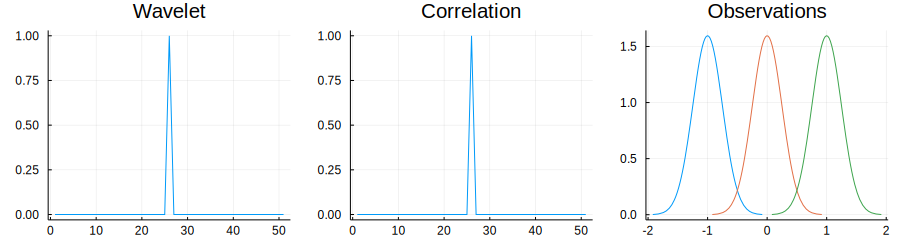

In [66]:
p = plot(layout=(1,3), size=(900,250), legend=false)
plot!(p, W[50,25:75], title="Wavelet")
plot!(p, Σ[50,25:75], sp=2, title="Correlation")
for t in zip(μ, σ²)
    plot!(p, Normal(t...), sp=3, title="Observations")
end
p

### 1.1 Truncation Approximation

  0.019858 seconds (216.41 k allocations: 14.921 MiB, 33.26% gc time)
Acceptance rate α = 0.9999999999999875

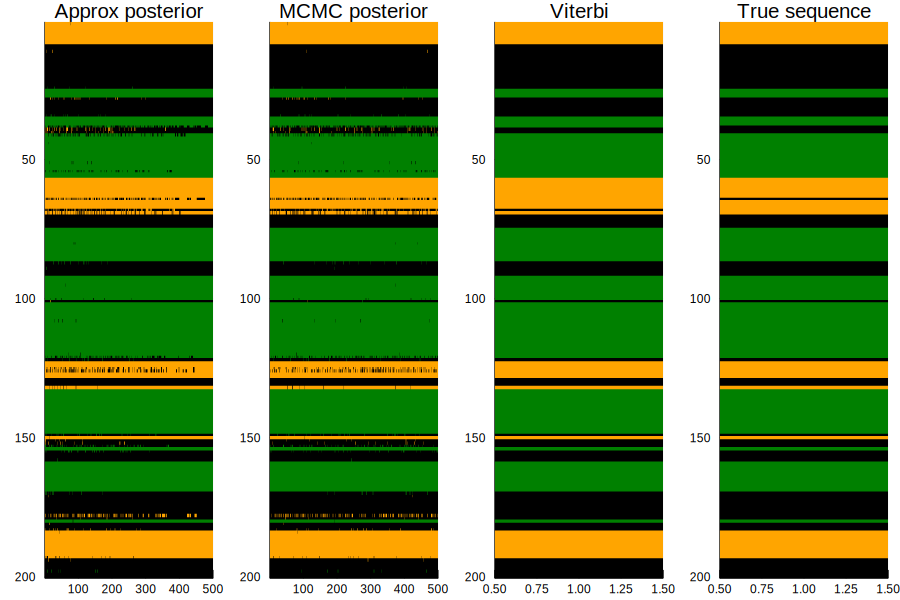

In [67]:
# approximation range
k = 3 

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time truncation = forward(hmm, d, k, Truncation)

# sample 500 profiles from approximate posterior
samples, lls_approx = sample(truncation, 500)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(truncation)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

### 1.2 Projection Approximation

  5.010483 seconds (292.88 k allocations: 9.862 GiB, 20.38% gc time)
Acceptance rate α = 0.9949451855068295

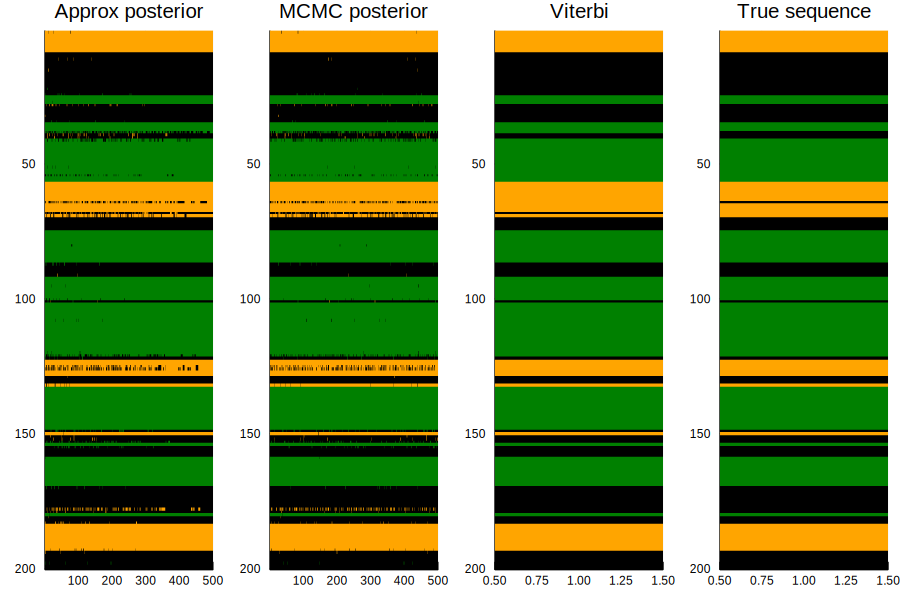

In [68]:
# approximation range
k = 3 

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time projection = forward(hmm, d, k, Projection)

# sample 500 profiles from approximate posterior
samples, lls_approx = sample(projection, 500)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(projection)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

## Case 2. Binary lithology, squared-exponential kernel, Ricker wavelet

In [81]:
P = [0.7 0.3; 0.3 0.7]

n = 100
μ, σ² = [3., 7.], [1., 1.]

σₙ² = 0.0005

# emission correlation kernel (squared-exponential)
ρ(h) = exp(-(h/3)^2)
Σ = kernelmatrix(ρ, n)

# wavelet (Ricker @100 Hz, 1ms sampling rate)
w = Ricker(100., 0.001)
W = kernelmatrix(w, n)

hmm = ConvolvedHMM(μ, σ², σₙ², W, Σ, P);
s, m, d = sample(hmm);
logpdf(hmm, s, d)

┌ Warning: differential matrix defaulted to identity
└ @ ConvHMM /mnt/d/Drive/research/Anadarko/codes/ConvHMM/src/convolvedhmm.jl:25


-25.073987567466418

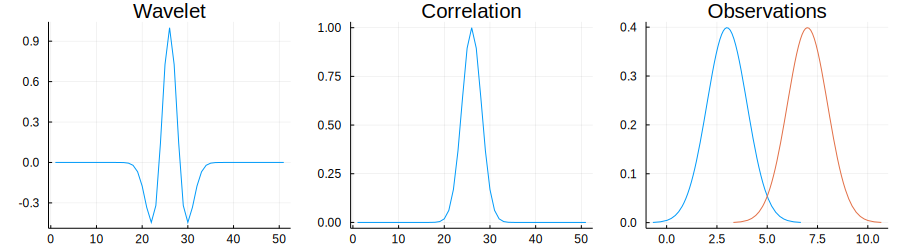

In [77]:
p = plot(layout=(1,3), size=(900,250), legend=false)
plot!(p, W[50,25:75], title="Wavelet")
plot!(p, Σ[50,25:75], sp=2, title="Correlation")
for t in zip(μ, σ²)
    plot!(p, Normal(t...), sp=3, title="Observations")
end
p

### 2.1 Truncation Approximation

  0.061437 seconds (549.01 k allocations: 77.100 MiB, 16.70% gc time)
Acceptance rate α = 0.03226224217289355

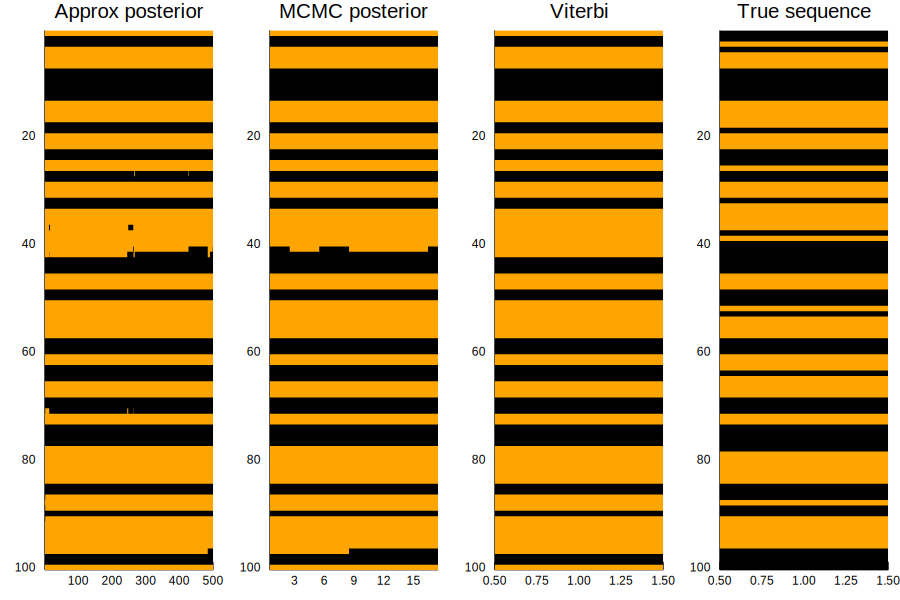

In [82]:
# approximation range
k = 7

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time truncation = forward(hmm, d, k, Truncation)

# sample 500 profiles from approximate posterior
samples, lls_approx = sample(truncation, 500)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(truncation)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

### 2.2 Projection Approximation

  3.455938 seconds (738.57 k allocations: 6.340 GiB, 20.12% gc time)
Acceptance rate α = 0.009819218553288784

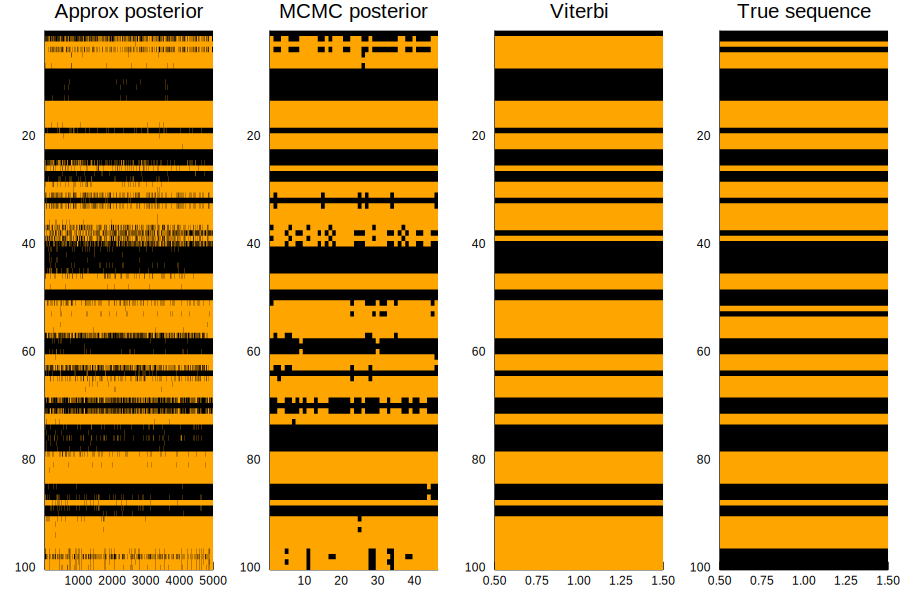

In [85]:
# approximation range
k = 7

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time projection = forward(hmm, d, k, Projection)

# sample 5000 profiles from approximate posterior
samples, lls_approx = sample(projection, 5000)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(projection)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

We can also plot posterior realizations of emission and data profiles:

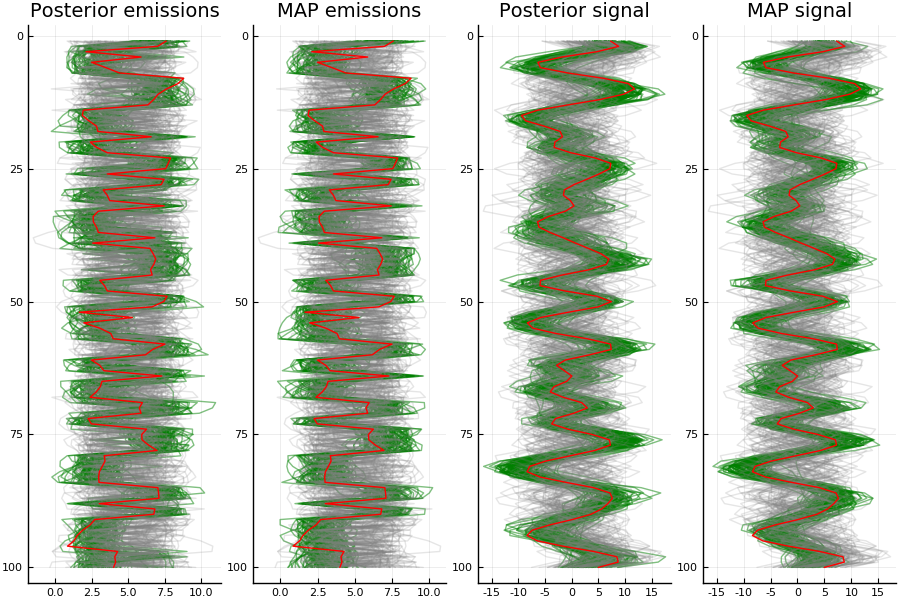

In [100]:
# plot sequences
p = plot(layout=(1,4), size=(900, 600),  yflip=true, cbar=false, legend=false)

# sample from prior over emissions and transformed signal
m_prior = hcat([sample(hmm)[2] for _ in 1:100]...)
d_prior = hcat([sample(hmm)[3] for _ in 1:100]...)

# sample emissions and transformed signal conditioned to posterior realizations over sequences
m_post = hcat([sample(hmm, rand(samples))[1] for _ in 1:100]...)
d_post = hcat([sample(hmm, rand(samples))[2] for _ in 1:100]...)

# sample emissions and transformed signal conditioned to VIterbi decoded sequence
m_map = hcat([sample(hmm, _map)[1] for _ in 1:100]...)
d_map = hcat([sample(hmm, _map)[2] for _ in 1:100]...)

plot!(p, m_post, 1:n, yflip=true, c=:green, alpha=0.5, sp=1, title="Posterior emissions")
plot!(p, m_prior, 1:n, c=:grey, alpha=0.2, sp=1)
plot!(p, m, 1:n, yflip=true, c=:red, sp=1)

plot!(p, m_map, 1:n, c=:green, alpha=0.5, sp=2, title="MAP emissions")
plot!(p, m_prior, 1:n, c=:grey, alpha=0.2, sp=2)
plot!(p, m, 1:n, yflip=true, c=:red, sp=2)

plot!(p, d_post, 1:n, yflip=true, c=:green, alpha=0.5, sp=3, title="Posterior signal")
plot!(p, d_prior, 1:n, c=:grey, alpha=0.2, sp=3)
plot!(p, d, 1:n, yflip=true, c=:red, sp=3)

plot!(p, d_map, 1:n, c=:green, alpha=0.5, sp=4, title="MAP signal")
plot!(p, d_prior, 1:n, c=:grey, alpha=0.2, sp=4)
plot!(p, d, 1:n, yflip=true, c=:red, sp=4)

## Case 3. Three lithology classes, same correlation and wavelet

In [106]:
P = [.8 .15 .05;
     .15 .75 .1;
     .05 .05 .9]

n = 200
μ, σ² = [-1., 0., 1.], [0.25 ,0.25, 0.25]
σₙ² = 0.0005

w = Ricker(100., 0.001)
W = kernelmatrix(w, n)

# emission correlation kernel (squared-exponential)
ρ(h) = exp(-(h/3)^2)
Σ = kernelmatrix(ρ, n)

hmm = ConvolvedHMM(μ, σ², σₙ², W, Σ, P)
s, m, d = sample(hmm)
logpdf(hmm, s, d)

┌ Warning: differential matrix defaulted to identity
└ @ ConvHMM /mnt/d/Drive/research/Anadarko/codes/ConvHMM/src/convolvedhmm.jl:25


76.87788528987049

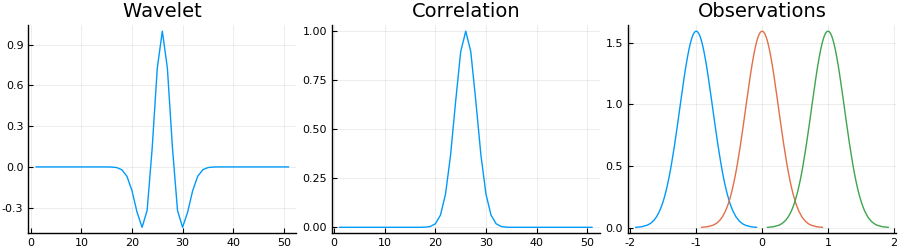

In [107]:
p = plot(layout=(1,3), size=(900,250), legend=false)
plot!(p, W[50,25:75], title="Wavelet")
plot!(p, Σ[50,25:75], sp=2, title="Correlation")
for t in zip(μ, σ²)
    plot!(p, Normal(t...), sp=3, title="Observations")
end
p

### 3.1 Truncation Approximation

  2.268234 seconds (18.27 M allocations: 2.548 GiB, 22.68% gc time)
Acceptance rate α = 0.012149195787963214

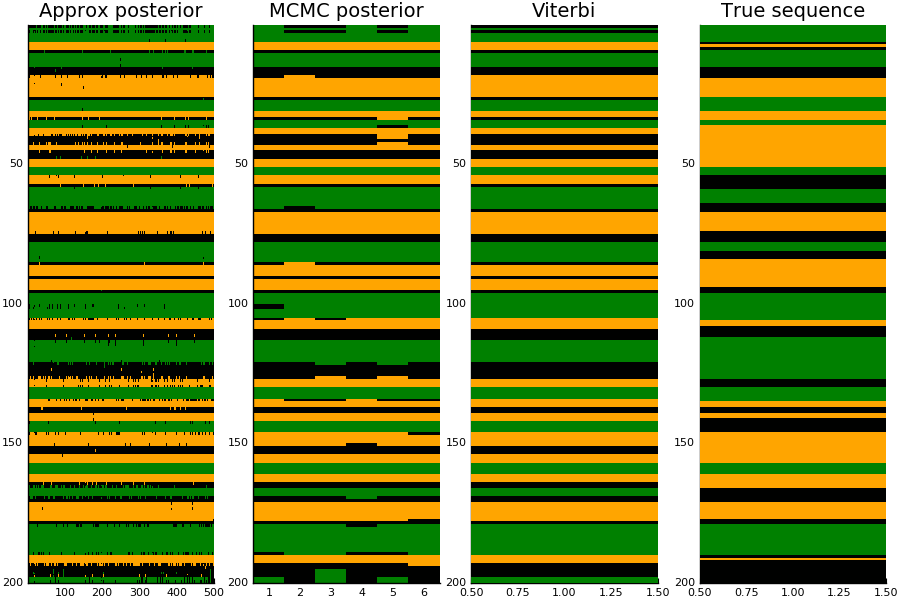

In [109]:
# approximation range
k = 7 

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time truncation = forward(hmm, d, k, Truncation)

# sample 500 profiles from approximate posterior
samples, lls_approx = sample(truncation, 500)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(truncation)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

### 3.2 Projection Approximation

430.375617 seconds (24.57 M allocations: 820.964 GiB, 26.08% gc time)
Acceptance rate α = 0.0027804352169633006

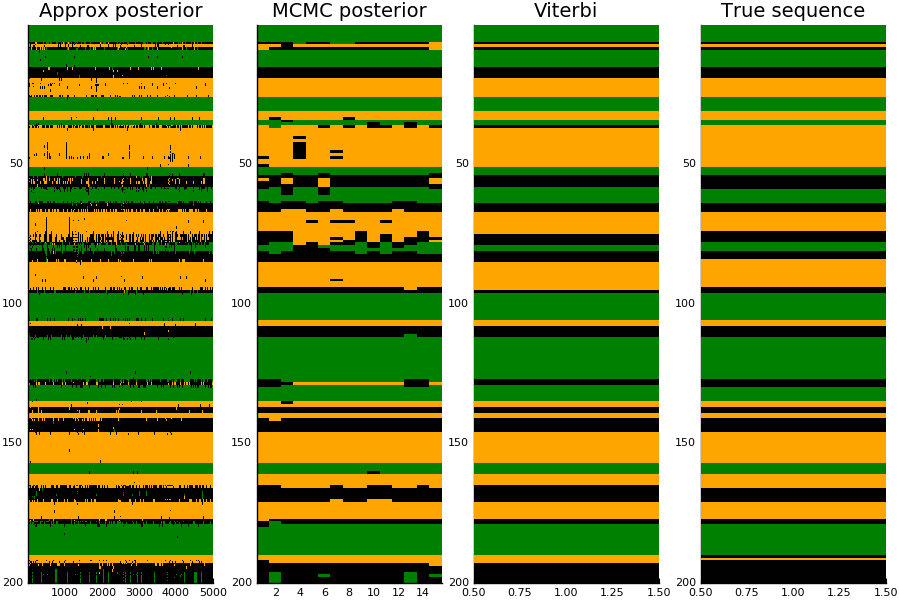

In [111]:
# approximation range
k = 7

# run forward with projection likelihood approximation. returns sampleable HMMApproximator object
@time projection = forward(hmm, d, k, Projection)

# sample 5000 profiles from approximate posterior
samples, lls_approx = sample(projection, 5000)

# compute true likelihoods
lls = map(x->logpdf(hmm, x, d), samples)

# MAP profile using Viterbi decoding
_map, map_ll = viterbi(projection)

# filter samples through independent proposal MH
samples_mcmc, α = mcmc(samples, lls, lls_approx)

print("Acceptance rate α = $α")

# plot sequences
p = plot(layout=(1,4), size=(900, 600), clims=(1,nk), yflip=true, cbar=false)
heatmap!(hcat(samples[sortperm(lls)]...),  sp=1, title="Approx posterior", c=cg)
heatmap!(hcat(samples_mcmc...), sp=2, title="MCMC posterior", c=cg)
heatmap!(_map[:,:], sp=3, title="Viterbi", c=cg)
heatmap!(s[:,:], sp=4, title="True sequence", c=cg)

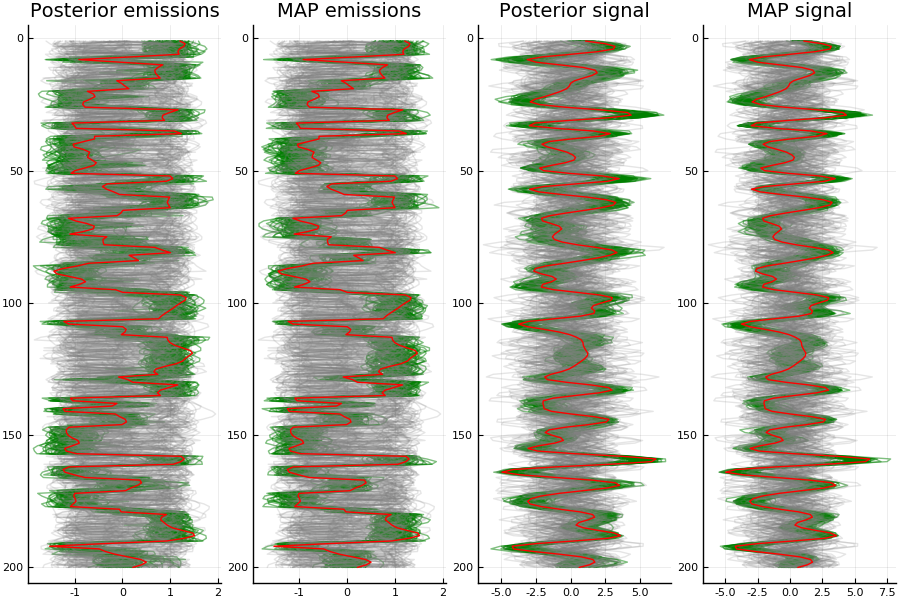

In [112]:
# plot sequences
p = plot(layout=(1,4), size=(900, 600),  yflip=true, cbar=false, legend=false)

# sample from prior over emissions and transformed signal
m_prior = hcat([sample(hmm)[2] for _ in 1:100]...)
d_prior = hcat([sample(hmm)[3] for _ in 1:100]...)

# sample emissions and transformed signal conditioned to posterior realizations over sequences
m_post = hcat([sample(hmm, rand(samples))[1] for _ in 1:100]...)
d_post = hcat([sample(hmm, rand(samples))[2] for _ in 1:100]...)

# sample emissions and transformed signal conditioned to VIterbi decoded sequence
m_map = hcat([sample(hmm, _map)[1] for _ in 1:100]...)
d_map = hcat([sample(hmm, _map)[2] for _ in 1:100]...)

plot!(p, m_post, 1:n, yflip=true, c=:green, alpha=0.5, sp=1, title="Posterior emissions")
plot!(p, m_prior, 1:n, c=:grey, alpha=0.2, sp=1)
plot!(p, m, 1:n, yflip=true, c=:red, sp=1)

plot!(p, m_map, 1:n, c=:green, alpha=0.5, sp=2, title="MAP emissions")
plot!(p, m_prior, 1:n, c=:grey, alpha=0.2, sp=2)
plot!(p, m, 1:n, yflip=true, c=:red, sp=2)

plot!(p, d_post, 1:n, yflip=true, c=:green, alpha=0.5, sp=3, title="Posterior signal")
plot!(p, d_prior, 1:n, c=:grey, alpha=0.2, sp=3)
plot!(p, d, 1:n, yflip=true, c=:red, sp=3)

plot!(p, d_map, 1:n, c=:green, alpha=0.5, sp=4, title="MAP signal")
plot!(p, d_prior, 1:n, c=:grey, alpha=0.2, sp=4)
plot!(p, d, 1:n, yflip=true, c=:red, sp=4)